In [1]:
import pandas as pd
import numpy as np
import re
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error
from sklearn import model_selection, pipeline, preprocessing, linear_model

import seaborn as sns
%matplotlib inline
%pylab inline

/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Populating the interactive namespace from numpy and matplotlib


In [2]:
df = pd.read_pickle('../data/df_all.pkl')
df.head()

,address,days_on_trulia,elementary_school_count,high_school_count,middle_school_count,pets_allowed,price,sqft,url,zip_code,...,demo_pct_two_or_more_races,demo_pct_white,demo_pct_black_or_african_american,demo_pct_american_indian_and_alaska_native,demo_pct_asian,demo_pct_native_hawaiian_and_other_pacific_islander,demo_pct_some_other_race,demo_pct_hispanic_or_latino_(of_any_race),rest_num,n_of_establishments
0,66 West 38th Street Manhattan NY,2,42,12,22,1,3795,None,https://www.trulia.com/p/ny/manhattan/66-w-38t...,10018,...,0.039550,0.591078,0.054936,0.000000,0.293474,0.000000,0.020962,0.165118,2879,6723
1,435 West 45th Street Manhattan NY,2,42,11,22,1,1950,500,https://www.trulia.com/p/ny/manhattan/435-w-45...,10036,...,0.020125,0.642167,0.074845,0.004579,0.192712,0.000000,0.065571,0.177435,1783,6131
2,56 West 11th Street Manhattan NY,14,42,16,19,0,4550,768,https://www.trulia.com/p/ny/manhattan/56-w-11t...,10011,...,0.029680,0.794004,0.045889,0.001270,0.101004,0.000079,0.028073,0.109456,2131,4002
3,298 Mulberry Street Manhattan NY,2,40,13,17,0,5350,None,https://www.trulia.com/p/ny/manhattan/298-mulb...,10012,...,0.038882,0.756643,0.026125,0.001549,0.161355,0.000489,0.014958,0.058730,2328,2972
4,71 West 107th Street Manhattan NY,14,27,6,15,0,2475,None,https://www.trulia.com/p/ny/manhattan/71-w-107...,10025,...,0.041946,0.659955,0.121467,0.008341,0.091821,0.000232,0.076238,0.227076,418,2027


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6342 entries, 0 to 6341
Data columns (total 78 columns):
address                                                6342 non-null object
days_on_trulia                                         6342 non-null int64
elementary_school_count                                6342 non-null int64
high_school_count                                      6342 non-null int64
middle_school_count                                    6342 non-null int64
pets_allowed                                           6342 non-null int64
price                                                  6342 non-null int64
sqft                                                   2318 non-null object
url                                                    6342 non-null object
zip_code                                               6342 non-null int64
evac                                                   1604 non-null object
guarantor                                              6342 non-

In [4]:
# check for nulls
df.columns[df.isna().any()].tolist()

['sqft',
 'evac',
 'pct_high_income',
 'demo_total_population',
 'demo_pct_male',
 'demo_pct_female',
 'demo_pct_under_5_years',
 'demo_pct_5_to_9_years',
 'demo_pct_10_to_14_years',
 'demo_pct_15_to_19_years',
 'demo_pct_20_to_24_years',
 'demo_pct_25_to_34_years',
 'demo_pct_35_to_44_years',
 'demo_pct_45_to_54_years',
 'demo_pct_55_to_59_years',
 'demo_pct_60_to_64_years',
 'demo_pct_65_to_74_years',
 'demo_pct_75_to_84_years',
 'demo_pct_85_years_and_over',
 'demo_pct_18_years_and_over',
 'demo_pct_21_years_and_over',
 'demo_pct_62_years_and_over',
 'demo_pct_65_years_and_over',
 'demo_pct_one_race',
 'demo_pct_two_or_more_races',
 'demo_pct_white',
 'demo_pct_black_or_african_american',
 'demo_pct_american_indian_and_alaska_native',
 'demo_pct_asian',
 'demo_pct_native_hawaiian_and_other_pacific_islander',
 'demo_pct_some_other_race',
 'demo_pct_hispanic_or_latino_(of_any_race)']

In [5]:
# check which zip codes have NULL values
df[pd.isnull(df.demo_total_population)]['zip_code'].unique()

array([11249])

In [6]:
# how many records contain this zip code
df[df['zip_code']==11249]['zip_code'].count()

70

In [7]:
# drop rows containing this zip code
df = df[df.zip_code != 11249].copy()

In [8]:
# check for nulls
df.evac.unique()

array([None, '2', '5', '4', '6', '1', '3', 'c'], dtype=object)

In [9]:
# fix feature name to feed to patsy
df.rename(columns={'flooring:_hardwood': 'flooring_hardwood'}, inplace=True)
df.rename(columns={'off-street_parking': 'off_street_parking'}, inplace=True)
df.rename(columns={'demo_pct_hispanic_or_latino_(of_any_race)': 'demo_pct_hispanic_or_latino'}, inplace=True)

In [10]:
df.loc[:, df.dtypes == object].head()

,address,sqft,url,evac
0,66 West 38th Street Manhattan NY,None,https://www.trulia.com/p/ny/manhattan/66-w-38t...,None
1,435 West 45th Street Manhattan NY,500,https://www.trulia.com/p/ny/manhattan/435-w-45...,None
2,56 West 11th Street Manhattan NY,768,https://www.trulia.com/p/ny/manhattan/56-w-11t...,None
3,298 Mulberry Street Manhattan NY,None,https://www.trulia.com/p/ny/manhattan/298-mulb...,None
4,71 West 107th Street Manhattan NY,None,https://www.trulia.com/p/ny/manhattan/71-w-107...,None


In [11]:
# create a list of all columns not related to demo data
non_demo_cols = [col for col in df.columns if 'demo' not in col]

In [12]:
# create a list with non-numerical columns 
non_num = ['address','url','evac','zip_code']
non_demo_cols = list(set(non_demo_cols).difference(set(non_num)))

# create a list with demo columns
demo_cols = [col for col in df.columns if 'demo' in col]
print('Non-demo columns:', len(non_demo_cols))
print('Demo columns:    ', len(demo_cols))

Non-demo columns: 45
Demo columns:     29


In [13]:
# create of non-demo numerical and booleam column lists
non_demo_num = ['sqft','median_income','middle_school_count','elementary_school_count',
               'high_school_count', 'n_of_establishments', 'rest_num', 'days_on_trulia', 'price', 'pct_high_income']

# create a list of binary columns
non_demo_bool = list(set(non_demo_cols).difference(set(non_demo_num)))

# remove dep var from non_demo_num list
non_demo_num.remove('price')

# remove sqft for now since it countains NULL values
non_demo_num.remove('sqft')

In [14]:
# list of non-binary variables
non_demo_num

['median_income',
 'middle_school_count',
 'elementary_school_count',
 'high_school_count',
 'n_of_establishments',
 'rest_num',
 'days_on_trulia',
 'pct_high_income']

In [15]:
# list of binary variables corresponding to the characteristics of the apartement
non_demo_bool

['co_purchase',
 'recreation_facilities',
 'air_conditioning',
 'garage',
 'fios_available',
 'flooring_hardwood',
 'cable_tv_ready',
 'sublets',
 'off_street_parking',
 'fireplace',
 'childrens_playroom',
 'pool',
 'pets_allowed',
 'live_in_super',
 'dryer',
 'dishwasher',
 'fitness_center',
 'terrace',
 'pets',
 'parents',
 'guarantor',
 'concierge',
 'board_approval_required',
 'balcony',
 'deck',
 'garden',
 'elevator',
 'valet_parking',
 'microwave_oven',
 'storage',
 'pied_a_terre',
 'furnished',
 'courtyard',
 'washing_machine',
 'leed_registered']

In [16]:
# demo variabes from Census data
demo_cols

['demo_total_population',
 'demo_pct_male',
 'demo_pct_female',
 'demo_pct_under_5_years',
 'demo_pct_5_to_9_years',
 'demo_pct_10_to_14_years',
 'demo_pct_15_to_19_years',
 'demo_pct_20_to_24_years',
 'demo_pct_25_to_34_years',
 'demo_pct_35_to_44_years',
 'demo_pct_45_to_54_years',
 'demo_pct_55_to_59_years',
 'demo_pct_60_to_64_years',
 'demo_pct_65_to_74_years',
 'demo_pct_75_to_84_years',
 'demo_pct_85_years_and_over',
 'demo_pct_18_years_and_over',
 'demo_pct_21_years_and_over',
 'demo_pct_62_years_and_over',
 'demo_pct_65_years_and_over',
 'demo_pct_one_race',
 'demo_pct_two_or_more_races',
 'demo_pct_white',
 'demo_pct_black_or_african_american',
 'demo_pct_american_indian_and_alaska_native',
 'demo_pct_asian',
 'demo_pct_native_hawaiian_and_other_pacific_islander',
 'demo_pct_some_other_race',
 'demo_pct_hispanic_or_latino']

In [17]:
# check dep var stats
df.price.describe()

count     6272.000000
mean      2720.768495
std       1542.082094
min        390.000000
25%       1799.000000
50%       2425.000000
75%       3286.500000
max      71850.000000
Name: price, dtype: float64

In [18]:
# see outliers on the high end
df[df.price>10000]

,address,days_on_trulia,elementary_school_count,high_school_count,middle_school_count,pets_allowed,price,sqft,url,zip_code,...,demo_pct_two_or_more_races,demo_pct_white,demo_pct_black_or_african_american,demo_pct_american_indian_and_alaska_native,demo_pct_asian,demo_pct_native_hawaiian_and_other_pacific_islander,demo_pct_some_other_race,demo_pct_hispanic_or_latino,rest_num,n_of_establishments
1059,160 Central Park South Manhattan NY,46,34,9,20,0,12900,750,https://www.trulia.com/p/ny/manhattan/160-cent...,10019,...,0.032907,0.697836,0.064574,0.004961,0.160891,0.001342,0.037489,0.152386,1782,4832
1221,795 5th Avenue New York NY,62,34,9,20,1,20000,975,https://www.trulia.com/p/ny/new-york/795-5th-a...,10065,...,0.011733,0.871571,0.033666,0.000467,0.077631,0.000600,0.004333,0.060631,1573,1492
1355,15 Central Park West Manhattan NY,77,30,10,21,1,11500,"1,342",https://www.trulia.com/p/ny/manhattan/15-centr...,10023,...,0.020993,0.820900,0.034159,0.001841,0.103968,0.000348,0.017792,0.105427,1225,2384
1368,128 East 70th Street Manhattan NY,79,32,9,20,0,10500,None,https://www.trulia.com/p/ny/manhattan/128-e-70...,10021,...,0.034931,0.826517,0.012726,0.006982,0.094563,0.001304,0.022978,0.074148,884,3009
1424,210 East 65th Street New York NY,90,33,8,20,1,11700,643,https://www.trulia.com/p/ny/new-york/210-e-65t...,10065,...,0.011733,0.871571,0.033666,0.000467,0.077631,0.000600,0.004333,0.060631,1112,1492
1537,160 Central Park South Manhattan NY,213,34,9,20,0,11300,791,https://www.trulia.com/p/ny/manhattan/160-cent...,10019,...,0.032907,0.697836,0.064574,0.004961,0.160891,0.001342,0.037489,0.152386,1782,4832
1814,166 Perry Street Manhattan NY,30,45,17,19,1,10500,"1,126",https://www.trulia.com/p/ny/manhattan/166-perr...,10014,...,0.018847,0.889207,0.013253,0.004005,0.056255,0.000000,0.018434,0.068332,1026,2454
1927,7 East 20th Street Manhattan NY,50,43,14,21,1,10900,"2,400",https://www.trulia.com/p/ny/manhattan/7-e-20th...,10003,...,0.028432,0.775116,0.043916,0.001850,0.129441,0.000141,0.021104,0.078743,2153,4318
2026,1 Central Park South Manhattan NY,101,35,10,20,1,12895,None,https://www.trulia.com/p/ny/manhattan/1-centra...,10019,...,0.032907,0.697836,0.064574,0.004961,0.160891,0.001342,0.037489,0.152386,1759,4832
2060,42 West 58th Street Manhattan NY,172,36,10,21,0,71850,"1,500",https://www.trulia.com/p/ny/manhattan/42-w-58t...,10019,...,0.032907,0.697836,0.064574,0.004961,0.160891,0.001342,0.037489,0.152386,1868,4832


In [19]:
# see outliers on the ;ow end
df[df.price<500]

,address,days_on_trulia,elementary_school_count,high_school_count,middle_school_count,pets_allowed,price,sqft,url,zip_code,...,demo_pct_two_or_more_races,demo_pct_white,demo_pct_black_or_african_american,demo_pct_american_indian_and_alaska_native,demo_pct_asian,demo_pct_native_hawaiian_and_other_pacific_islander,demo_pct_some_other_race,demo_pct_hispanic_or_latino,rest_num,n_of_establishments
3496,117 Avenue T Brooklyn NY,19,56,6,35,0,390,None,https://www.trulia.com/rental/4045692209-117-A...,11223,...,0.019441,0.633375,0.041402,0.004979,0.229437,0.002069,0.069296,0.134705,190,2137


In [20]:
df[non_demo_num].describe()

,median_income,middle_school_count,elementary_school_count,high_school_count,n_of_establishments,rest_num,days_on_trulia,pct_high_income
count,6272.000000,6272.000000,6272.00000,6272.000000,6272.000000,6272.000000,6272.000000,6272.000000
mean,77900.886001,19.960938,35.81824,8.689573,2308.647800,843.970823,27.099171,15.028189
std,32224.488307,6.785896,11.23259,4.436418,1656.241665,1118.292186,40.366769,11.589212
min,21553.000000,6.000000,15.00000,2.000000,74.000000,1.000000,-1.000000,0.400000
25%,51864.000000,15.000000,26.00000,5.000000,1079.000000,253.000000,6.000000,4.200000
50%,75362.000000,19.000000,35.00000,8.000000,1967.000000,452.000000,15.000000,10.400000
75%,108178.000000,23.000000,42.00000,12.000000,3015.000000,1180.250000,34.000000,24.900000
max,250001.000000,41.000000,64.00000,28.000000,7373.000000,11931.000000,889.000000,59.900000


In [21]:
# check negative values in 'days on Trulia' 
df.loc[df.days_on_trulia < 0]

,address,days_on_trulia,elementary_school_count,high_school_count,middle_school_count,pets_allowed,price,sqft,url,zip_code,...,demo_pct_two_or_more_races,demo_pct_white,demo_pct_black_or_african_american,demo_pct_american_indian_and_alaska_native,demo_pct_asian,demo_pct_native_hawaiian_and_other_pacific_islander,demo_pct_some_other_race,demo_pct_hispanic_or_latino,rest_num,n_of_establishments
2072,323 East 75th Street Manhattan NY,-1,30,7,19,0,4750,None,https://www.trulia.com/p/ny/manhattan/323-e-75...,10021,...,0.034931,0.826517,0.012726,0.006982,0.094563,0.001304,0.022978,0.074148,739,3009
2073,185 Bleecker Street Manhattan NY,-1,42,14,19,0,3200,None,https://www.trulia.com/p/ny/manhattan/185-blee...,10012,...,0.038882,0.756643,0.026125,0.001549,0.161355,0.000489,0.014958,0.058730,1655,2972
2075,1657 Madison Avenue Manhattan NY,-1,27,6,16,0,1800,None,https://www.trulia.com/p/ny/manhattan/1657-mad...,10029,...,0.026218,0.346891,0.289418,0.002330,0.087041,0.001574,0.246528,0.474065,480,1065
2076,75 East 3rd Street Manhattan NY,-1,40,13,17,0,2750,None,https://www.trulia.com/p/ny/manhattan/75-e-3rd...,10003,...,0.028432,0.775116,0.043916,0.001850,0.129441,0.000141,0.021104,0.078743,1945,4318
2077,330 East 38th Street Manhattan NY,-1,40,14,21,1,3800,763,https://www.trulia.com/p/ny/manhattan/330-e-38...,10016,...,0.038260,0.726072,0.030469,0.001348,0.195702,0.000000,0.008148,0.086056,1383,6042
2078,346 West 36th Street Manhattan NY,-1,42,12,22,1,2000,600,https://www.trulia.com/p/ny/manhattan/346-w-36...,10018,...,0.039550,0.591078,0.054936,0.000000,0.293474,0.000000,0.020962,0.165118,2068,6723
2079,92 Morningside Avenue Manhattan NY,-1,25,4,13,0,3256,None,https://www.trulia.com/p/ny/manhattan/92-morni...,10027,...,0.036385,0.299969,0.414005,0.004757,0.096709,0.000078,0.148097,0.240814,449,1049
2081,328 East 15th Street Manhattan NY,-1,42,16,20,1,2400,700,https://www.trulia.com/p/ny/manhattan/328-e-15...,10003,...,0.028432,0.775116,0.043916,0.001850,0.129441,0.000141,0.021104,0.078743,1516,4318
2082,377 Rector Place Manhattan NY,-1,39,14,19,1,3050,654,https://www.trulia.com/p/ny/manhattan/377-rect...,10280,...,0.028949,0.770340,0.015846,0.000000,0.165566,0.000000,0.019299,0.112443,908,163


In [22]:
# after checking on site, it looks like -1 value was meant to be 1
# change 1 day and 0 days to 1 to be able to put a log on it
df.loc[df.days_on_trulia < 1, 'days_on_trulia'] = 1

# Visualization

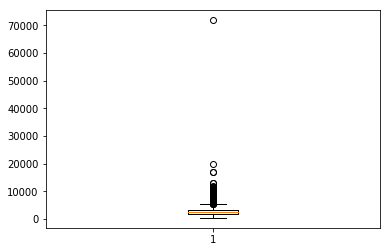

In [23]:
# dep variable distribution
plt.boxplot(df.price);

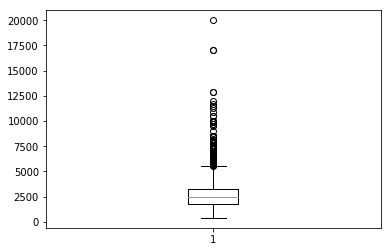

In [24]:
# remove the outlier and plot
df = df[df.price<70000].copy()
# dep variable distribution
plt.boxplot(df.price);

Text(0.5,1,'Monthly 1br Rent Price')

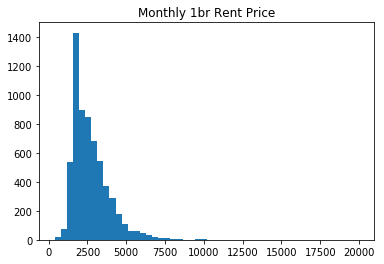

In [25]:
plt.hist(df.price, bins = 50);
plt.title('Monthly 1br Rent Price')

Text(0,0.5,'log scale')

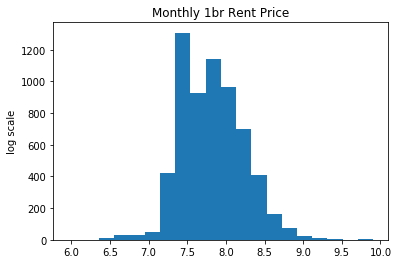

In [26]:
# the data is right-skewed: create a dep var column on a log scale & plot
# df['price_log'] = np.log(df.price)
plt.hist(np.log(df.price), bins = 20);
plt.title('Monthly 1br Rent Price')
plt.ylabel('log scale')

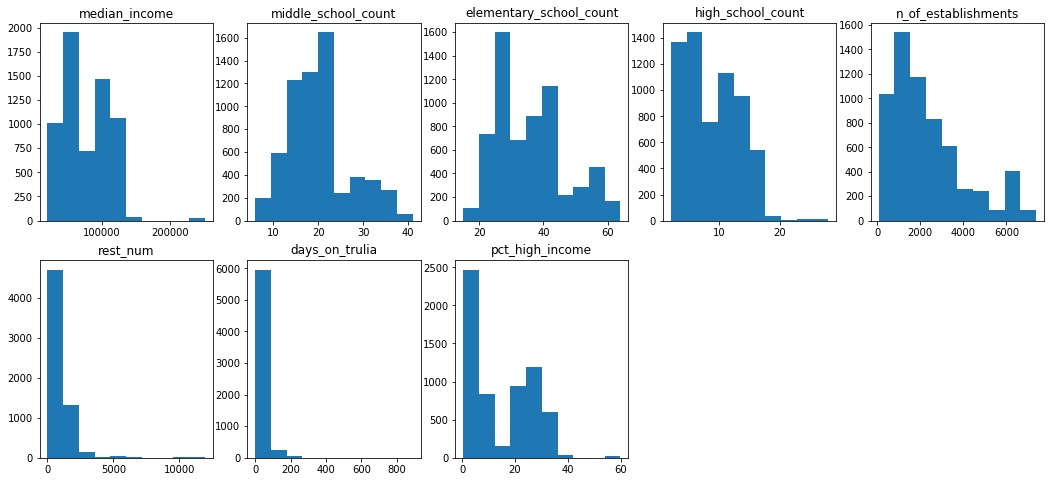

In [27]:
# plot distributions of non-binary variables
plt.figure(figsize=(18, 8))

for var in non_demo_num:
    plt.subplot(2, 5, non_demo_num.index(var)+1)
    plt.hist(df[var])
    plt.title(var);

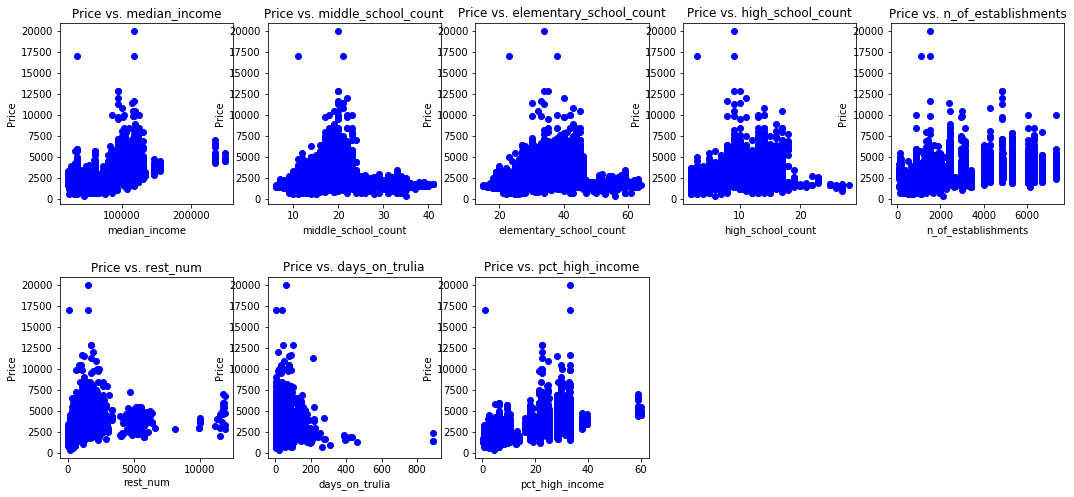

In [28]:
# create scatter plolts with dep var against non_demo_num vars
plt.figure(figsize=(18, 8))
y = df['price']
for var in non_demo_num:
    plt.subplot(2, 5, non_demo_num.index(var)+1)
    plt.plot(df[var], y,'bo')
    plt.subplots_adjust(hspace = 0.4)
    plt.xlabel(var)
    plt.ylabel('Price')
    plt.title(f'Price vs. {var}');

### Observations:
- The number of schools in the neighborhood doesn't seem to be correlated to the price, which is not suprprising for one bedroom apartements

In [29]:
# change highly-skewed variables into log vars
log_vars = ['median_income','pct_high_income','rest_num','days_on_trulia']

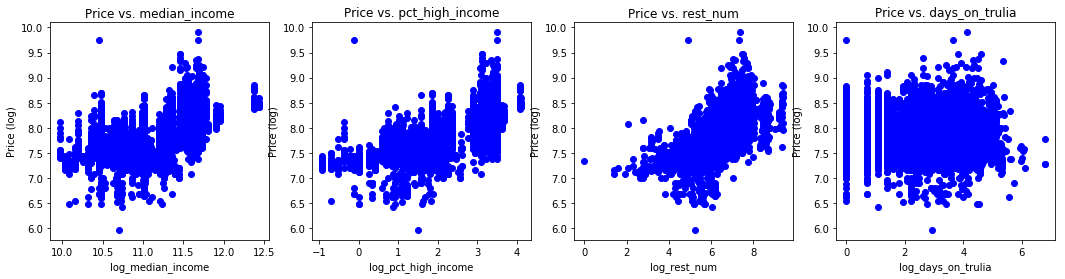

In [30]:
# create scatter plolts with dep var (log) against non_demo_num log-tansformd vars vars
plt.figure(figsize=(18, 4))
y = np.log(df.price)
for var in log_vars:
    plt.subplot(1, 4, log_vars.index(var)+1)
    x_var = np.log(df[var])
    plt.plot(x_var, y,'bo')
    plt.xlabel(f'log_{var}')
    plt.ylabel('Price (log)')
    plt.title(f'Price vs. {var}');

### Observations:
- Number of restaurants (log rest_num) has positive correlation with apt price <br>
- % of HI households (pct_hight_income) also has a positive correlation with apt price <br>

In [31]:
# school count variables are expected to be multicollinear, let's test that
school_vars = ['middle_school_count', 'elementary_school_count','high_school_count']

df[['middle_school_count', 'elementary_school_count','high_school_count','price']].corr()

,middle_school_count,elementary_school_count,high_school_count,price
middle_school_count,1.000000,0.871883,0.415667,-0.093755
elementary_school_count,0.871883,1.000000,0.593135,0.007522
high_school_count,0.415667,0.593135,1.000000,0.409157
price,-0.093755,0.007522,0.409157,1.000000


### Obesrvations:
- There is a collinearity between elementary school and middle school
- High school has moderate correlation with elementary school
- Our dep var has a very low correlation with school-counts, with the expection of high school

In [32]:
len(non_demo_bool)

35

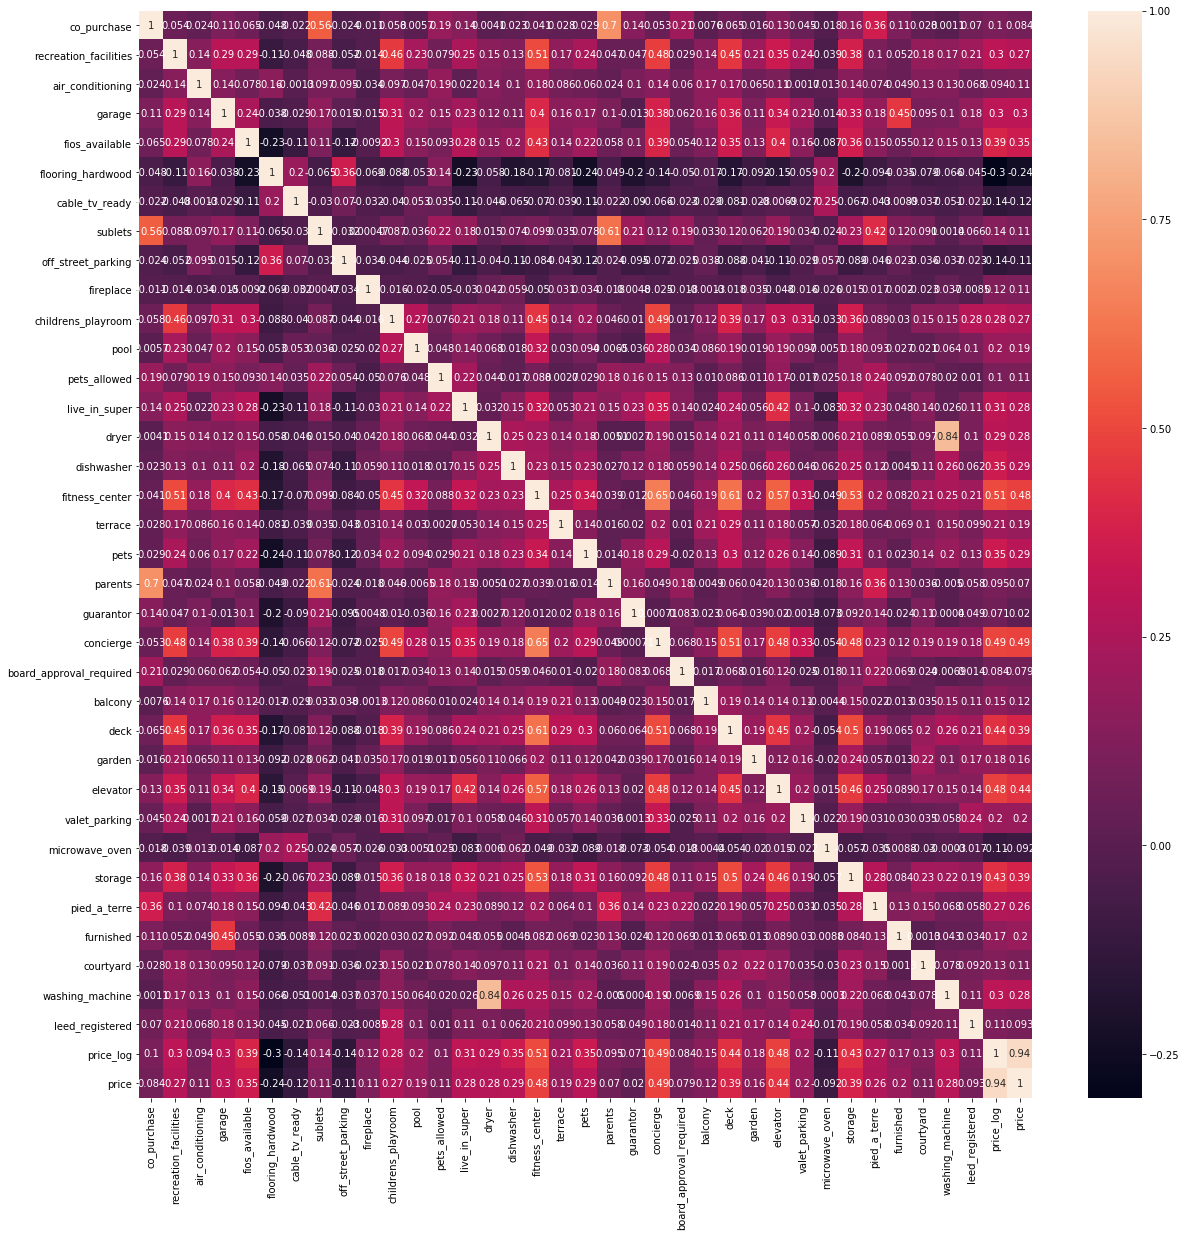

In [33]:
# test correlation between dep var, log-transformed dep var and non-demo binary features
df_test = df[non_demo_bool].copy()

df_test['price_log'] = np.log(df.price).copy()

df_test['price'] = df.price.copy()

df_test.head()

f, ax = plt.subplots(figsize = (20,20))
sns.heatmap(df_test.corr(), annot=True)
plt.show()

### Observations:
- from all features 'fitness center' has the highest correlation with the 1br apt rent price
- concierge, garage, deck and storage also have moderate correlation with rent price
- washing machine should be merged with dryer into one since they are highly correlated features

In [34]:
# merge washing machine and dryer since one comes with another in the apts
df['wash_dry'] = df.loc[(df['washing_machine'] == 1) |  (df['dryer'] == 1), 'wash_dry'] = 1
# drop the other two columns
df.drop(labels = ['washing_machine', 'dryer'], axis=1, inplace=True)
# update non_demo_bool list
non_demo_bool.remove('washing_machine')
non_demo_bool.remove('dryer')
non_demo_bool.append('wash_dry')

# Modeling

### Statmodels

In [35]:
# split data into test and train 
# x = df.drop(labels=['price','address','sqft','url','evac','zip_code'], axis=1)
# y = df['price']

# X_train , X_test, y_train, y_test = model_selection.train_test_split(x,y, test_size = 0.2)

In [36]:
# use patsy on non_demo_num features only
df_train = X_train[non_demo_num].copy()
df_train['price'] = y_train

df_test = X_test[non_demo_num].copy()
df_test['price'] = y_test

# create a string for patsy input
non_demo_num_str = 'price' + ' ~ ' + ' + '.join(non_demo_num)
non_demo_num_str

'price ~ median_income + middle_school_count + elementary_school_count + high_school_count + n_of_establishments + rest_num + days_on_trulia + pct_high_income'

In [37]:
# create feature matrix (X) and target vector (y)
y_sm, X_sm = patsy.dmatrices(non_demo_num_str, data=df_train, return_type="dataframe")
# create model
model = sm.OLS(y_sm, X_sm)
# fit model to training set
fit1 = model.fit()

fit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.462
Model:                            OLS   Adj. R-squared:                  0.461
Method:                 Least Squares   F-statistic:                     537.7
Date:                Wed, 25 Apr 2018   Prob (F-statistic):               0.00
Time:                        23:42:31   Log-Likelihood:                -41348.
No. Observations:                5016   AIC:                         8.271e+04
Df Residuals:                    5007   BIC:                         8.277e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                2034.7321     70.002     29.067      0.000    1897.497    2171.967
median_income              -0.0095      0.002     -6.126      0.000      -0.013      -0.006
middle_school_count       -15.0305      4.112     -3.655      0.000     -23.093      -6.969
elementary_school_count    -2.4176      2.877     -0.840      0.401      -8.058       3.223
high_school_count          41.6092      4.831      8.614      0.000      32.139      51.079
n_of_establishments         0.0605      0.011      5.572      0.000       0.039       0.082
rest_num                    0.1643      0.015     11.310      0.000       0.136       0.193
days_on_trulia              1.4473      0.335      4.315      0.000       0.790       2.105
pct_high_income            74.5583      4.684     15.918      0.000      65.376      83.741
==============================================================================
Omnibus:                     4571.009   Durbin-Watson:                   1.972
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           449841.330
Skew:                           3.977   Prob(JB):                         0.00
Kurtosis:                      48.707   Cond. No.                     4.55e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.55e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Observations:
- Based on the Skewness number and very high Kurtosis, the values have heavy tails and a single high peak

In [38]:
# test statmodels on log-transformed dep var and log-transformed vars that don't have normal distribution

df_train = X_train[non_demo_num].copy()
df_train['price_log'] = np.log(y_train)

df_test = X_test[non_demo_num].copy()
df_test['price_log'] = np.log(y_test)

for var in log_vars:
    df_train[var] = np.log(df_train[var])
    df_test[var] = np.log(df_test[var])
    
# create a string for patsy input
non_demo_num_str = 'price_log' + ' ~ ' + ' + '.join(non_demo_num)
non_demo_num_str

'price_log ~ median_income + middle_school_count + elementary_school_count + high_school_count + n_of_establishments + rest_num + days_on_trulia + pct_high_income'

In [39]:
# create feature matrix (X) and target vector (y)
y_sm, X_sm = patsy.dmatrices(non_demo_num_str, data=df_train, return_type="dataframe")
# create model
model = sm.OLS(y_sm, X_sm)
# fit model to training set
fit2 = model.fit()

fit2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.618
Model:                            OLS   Adj. R-squared:                  0.618
Method:                 Least Squares   F-statistic:                     1013.
Date:                Wed, 25 Apr 2018   Prob (F-statistic):               0.00
Time:                        23:42:35   Log-Likelihood:                -175.44
No. Observations:                5016   AIC:                             368.9
Df Residuals:                    5007   BIC:                             427.6
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   8.1769      0.241     33.921      0.000       7.704       8.649
median_income              -0.1479      0.023     -6.387      0.000      -0.193      -0.103
middle_school_count        -0.0036      0.001     -3.170      0.002      -0.006      -0.001
elementary_school_count    -0.0032      0.001     -4.105      0.000      -0.005      -0.002
high_school_count           0.0159      0.001     12.406      0.000       0.013       0.018
n_of_establishments     -1.349e-06   3.11e-06     -0.433      0.665   -7.45e-06    4.76e-06
rest_num                    0.1278      0.005     24.975      0.000       0.118       0.138
days_on_trulia              0.0180      0.003      6.597      0.000       0.013       0.023
pct_high_income             0.2221      0.011     21.120      0.000       0.201       0.243
==============================================================================
Omnibus:                      621.131   Durbin-Watson:                   1.952
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3897.369
Skew:                           0.415   Prob(JB):                         0.00
Kurtosis:                       7.238   Cond. No.                     1.94e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.94e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

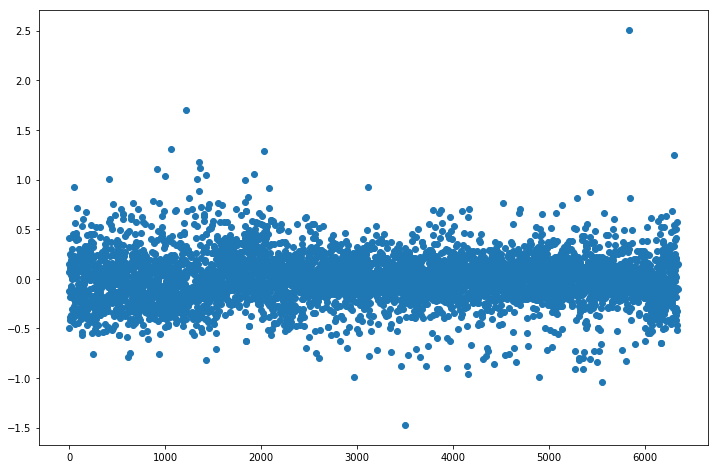

In [40]:
# Use statsmodels to plot the residuals
fit2.resid.plot(style='o', figsize=(12,8))

In [41]:
# use patsy on all features

df_train = X_train.copy()
df_train['price_log'] = np.log(y_train)

df_test = X_test.copy()
df_test['price_log'] = np.log(y_test)

for var in log_vars:
    df_train[var] = np.log(df_train[var])
    df_test[var] = np.log(df_test[var])

# create a string for patsy input
all_features_str = 'price_log' + ' ~ ' + ' + '.join(list(X_train.columns))

# create feature matrix (X) and target vector (y)
y_sm, X_sm = patsy.dmatrices(all_features_str, data=df_train, return_type="dataframe")
# create model
model = sm.OLS(y_sm, X_sm)
# fit model to training set
fit3 = model.fit()

fit3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.752
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     227.1
Date:                Wed, 25 Apr 2018   Prob (F-statistic):               0.00
Time:                        23:42:41   Log-Likelihood:                 905.21
No. Observations:                5016   AIC:                            -1676.
Df Residuals:                    4949   BIC:                            -1240.
Df Model:                          66                                         
Covariance Type:            nonrobust                                         
=======================================================================================================================
                                                          coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------
Intercept                                           -1.517e+06   1.21e+06     -1.255      0.209   -3.89e+06    8.52e+05
days_on_trulia                                          0.0110      0.002      4.853      0.000       0.007       0.015
elementary_school_count                                -0.0002      0.001     -0.319      0.750      -0.002       0.001
high_school_count                                       0.0106      0.001      8.717      0.000       0.008       0.013
middle_school_count                                    -0.0041      0.001     -3.600      0.000      -0.006      -0.002
pets_allowed                                            0.0171      0.007      2.418      0.016       0.003       0.031
guarantor                                              -0.0344      0.008     -4.578      0.000      -0.049      -0.020
storage                                                 0.0330      0.009      3.821      0.000       0.016       0.050
garage                                                 -0.0017      0.010     -0.171      0.864      -0.022       0.018
deck                                                    0.0360      0.010      3.580      0.000       0.016       0.056
elevator                                                0.1007      0.008     12.442      0.000       0.085       0.117
dishwasher                                              0.0689      0.007     10.205      0.000       0.056       0.082
pets                                                    0.0284      0.007      4.034      0.000       0.015       0.042
fios_available                                          0.0276      0.007      3.737      0.000       0.013       0.042
live_in_super                                          -0.0292      0.008     -3.824      0.000      -0.044      -0.014
fitness_center                                          0.0873      0.011      7.608      0.000       0.065       0.110
concierge                                               0.0861      0.012      7.027      0.000       0.062       0.110
balcony                                                 0.0308      0.009      3.256      0.001       0.012       0.049
air_conditioning                                        0.0319      0.010      3.234      0.001       0.013       0.051
flooring_hardwood                                      -0.0198      0.012     -1.691      0.091      -0.043       0.003
recreation_facilities                                  -0.0130      0.013     -0.985      0.325      -0.039       0.013
garden                                                  0.0685      0.011      6.163      0.000       0.047       0.090
pied_a_terre                                            0.0613      0.014      4.52

In [46]:
# model only with features with p-val < 0.05
low_p_feat = ['days_on_trulia','high_school_count','middle_school_count','guarantor',
              'storage','deck','elevator','dishwasher','pets','fios_available','live_in_super',
              'fitness_center','concierge','balcony','garden','pied_a_terre','terrace',
              'pool','furnished','fireplace','sublets','median_income','pct_high_income',
              'demo_pct_18_years_and_over','rest_num','n_of_establishments']

In [47]:
df_train = X_train[low_p_feat].copy()
df_train['price_log'] = np.log(y_train)

df_test = X_test[low_p_feat].copy()
df_test['price_log'] = np.log(y_test)

for var in log_vars:
    df_train[var] = np.log(df_train[var])
    df_test[var] = np.log(df_test[var])

# create a string for patsy input
low_p_feat_str = 'price_log' + ' ~ ' + ' + '.join(low_p_feat)

# create feature matrix (X) and target vector (y)
y_sm, X_sm = patsy.dmatrices(low_p_feat_str, data=df_train, return_type="dataframe")
# create model
model = sm.OLS(y_sm, X_sm)
# fit model to training set
fit4 = model.fit()

fit4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.740
Method:                 Least Squares   F-statistic:                     549.4
Date:                Wed, 25 Apr 2018   Prob (F-statistic):               0.00
Time:                        23:49:21   Log-Likelihood:                 799.53
No. Observations:                5016   AIC:                            -1545.
Df Residuals:                    4989   BIC:                            -1369.
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      7.4112      0.205     36.235      0.000       7.010       7.812
days_on_trulia                 0.0105      0.002      4.628      0.000       0.006       0.015
high_school_count              0.0115      0.001     12.390      0.000       0.010       0.013
middle_school_count           -0.0061      0.001    -11.459      0.000      -0.007      -0.005
guarantor                     -0.0253      0.007     -3.440      0.001      -0.040      -0.011
storage                        0.0342      0.009      3.972      0.000       0.017       0.051
deck                           0.0324      0.010      3.286      0.001       0.013       0.052
elevator                       0.0986      0.008     12.294      0.000       0.083       0.114
dishwasher                     0.0720      0.007     10.734      0.000       0.059       0.085
pets                           0.0300      0.007      4.245      0.000       0.016       0.044
fios_available                 0.0337      0.007      4.618      0.000       0.019       0.048
live_in_super                 -0.0259      0.008     -3.452      0.001      -0.041      -0.011
fitness_center                 0.0827      0.011      7.354      0.000       0.061       0.105
concierge                      0.0751      0.012      6.477      0.000       0.052       0.098
balcony                        0.0374      0.009      3.975      0.000       0.019       0.056
garden                         0.0639      0.011      5.840      0.000       0.042       0.085
pied_a_terre                   0.0582      0.013      4.390      0.000       0.032       0.084
terrace                        0.0429      0.013      3.235      0.001       0.017       0.069
pool                           0.0883      0.014      6.159      0.000       0.060       0.116
furnished                      0.0938      0.014      6.504      0.000       0.066       0.122
fireplace                      0.1105      0.015      7.356      0.000       0.081       0.140
sublets                       -0.0934      0.018     -5.138      0.000      -0.129      -0.058
median_income                 -0.0845      0.020     -4.320      0.000      -0.123      -0.046
pct_high_income                0.1601      0.009     17.901      0.000       0.143       0.178
demo_pct_18_years_and_over     0.3037      0.086      3.524      0.000       0.135       0.473
rest_num                       0.0980      0.005     20.880      0.000       0.089       0.107
n_of_establishments        -1.069e-05   2.62e-06     -4.082      0.000   -1.58e-05   -5.55e-06
==============================================================================
Omnibus:                     1091.879   Durbin-Watson:                   1.955
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            15161.

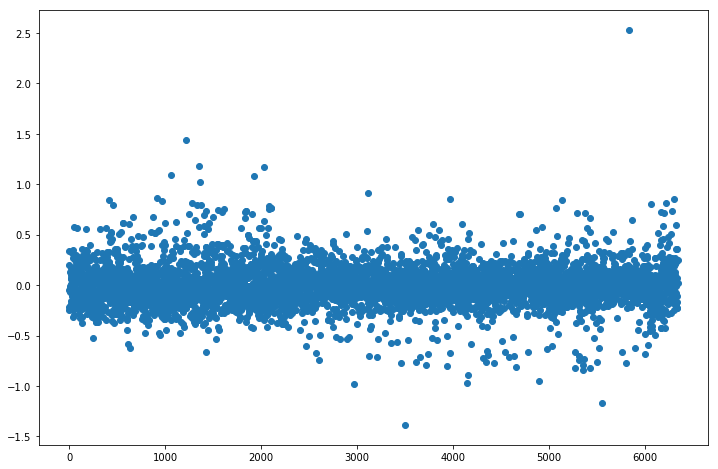

In [54]:
# Use statsmodels to plot the residuals
fit4.resid.plot(style='o', figsize=(12,8))

## Sklearn

In [59]:
from sklearn.linear_model import Lasso, Ridge
from sklearn.model_selection import GridSearchCV
from sklearn import pipeline, feature_selection, model_selection, linear_model, preprocessing

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, cross_val_score

stdsc = StandardScaler()

In [83]:
# Set a benchmark for linear regression model - MSE
y_mean = df['price'].mean()
MSE_benchmark = ((df['price'] - y_mean)**2).mean()
print("Performance benchmark MSE = ", (MSE_benchmark))

Performance benchmark MSE =  1615840.0672574576


### 1.1 Run Linear Regression with all features and identify the most important ones

In [76]:
X_train_lr = X_train.copy()
y_train_lr = y_train.copy()

X_test_lr = X_test.copy()
y_test_lr = y_test.copy()

In [77]:
lr = LinearRegression(fit_intercept=True, normalize=True)
lr.fit(X_train_lr, y_train_lr)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)

In [78]:
lr.intercept_

2.669798305969993e+17

In [79]:
print(lr.score(X_train_lr, y_train_lr))
print(lr.score(X_test_lr, y_test_lr))

0.6170745941461194
0.5847633157202645


In [80]:
# get coefficients 
feature_coefs = pd.DataFrame({'Features':X_train_lr.columns,'Coef':lr.coef_})
feature_coefs.sort_values(by = 'Coef', ascending=False)

,Coef,Features
59,8.174612e+16,demo_pct_one_race
60,8.174612e+16,demo_pct_two_or_more_races
58,3.011992e+10,demo_pct_65_years_and_over
44,1.210458e+10,demo_pct_10_to_14_years
51,1.210457e+10,demo_pct_60_to_64_years
43,1.210457e+10,demo_pct_5_to_9_years
46,1.210457e+10,demo_pct_20_to_24_years
47,1.210457e+10,demo_pct_25_to_34_years
48,1.210457e+10,demo_pct_35_to_44_years
42,1.210457e+10,demo_pct_under_5_years


### 1.2 Linear Regression with log-transformed dep var and non-nonrmaly distributed vars

In [81]:
X_train_lr = X_train.copy()
y_train_lr = np.log(y_train)

X_test_lr = X_test.copy()
y_test_lr = np.log(y_test)

for var in log_vars:
    X_train_lr[var] = np.log(X_train_lr[var])
    X_test_lr[var] = np.log(X_test_lr[var])

In [82]:
lr2.fit(X_train_lr, y_train_lr)
print(lr2.score(X_train_lr, y_train_lr))
print(lr2.score(X_test_lr, y_test_lr))

0.7517475777596039
0.749334119593283


### 1.3. Use SelektKBest on log-transformed dep var

In [85]:
x = df.drop(labels=['price','address','sqft','url','evac','zip_code'], axis=1)
y = np.log(df['price'])

for var in log_vars:
    x[var] = np.log(x[var])

In [86]:
select_pipe = pipeline.Pipeline(
    [("select",
      feature_selection.SelectKBest(
          score_func=feature_selection.f_regression, k=3)),
     ("ols", linear_model.LinearRegression())])
select_pipe.get_params()

In [89]:
len(x.columns)

71

In [100]:
import warnings
warnings.filterwarnings("ignore")

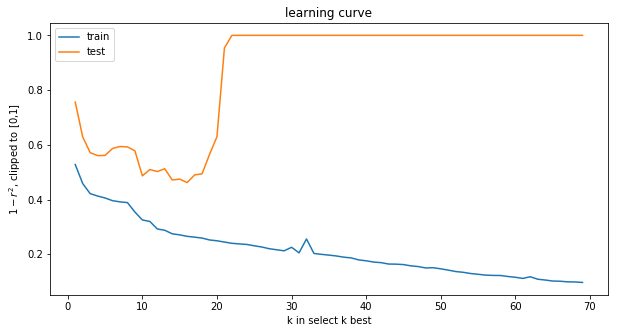

In [101]:
figsize(10, 5)
train_scores = []
test_scores = []
num_fs = range(1,70, 1)
for i, num_f in enumerate(num_fs):
    select_pipe.set_params(select__k=num_f)
    cv_result = model_selection.cross_validate(
        select_pipe, X=x, y=y, cv=3, return_train_score=True)
    train_scores.append(np.mean(cv_result['train_score']))
    test_scores.append(np.mean(cv_result['test_score']))

plot(num_fs, 1 - np.array(train_scores), label="train")
plot(num_fs, 1 - np.maximum(test_scores, 0), label="test")
xlabel("k in select k best")
ylabel("$1-r^2$, clipped to [0,1]")
title("learning curve")
legend()

# impute sqft - (options: mean/ make linear regression to predict sqft)
# get lat/long data
- run a test on sqft make a smaller model on those
- make a little regression on predicting sqft 
- 